<a href="https://colab.research.google.com/github/SheshamJoseph/malaria_detection/blob/main/malaria_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Malaria Detection

## Preprocess the data

### Fetching the data

In [ ]:
!wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip

--2025-06-26 09:35:04--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 108.159.227.37, 108.159.227.114, 108.159.227.36, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|108.159.227.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  30.3MB/s    in 6.6s    

2025-06-26 09:35:11 (51.1 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]



In [ ]:
# unzip the files
import zipfile
zip_ref = zipfile.ZipFile('/content/cell_images.zip')
zip_ref.extractall()
zip_ref.close()

In [ ]:
# Perform OS walk through directory and list number of files
import os

for dirpath, dirnames, filenames in os.walk('/content/cell_images'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in /content/cell_images
There are 0 directories and 13780 images in /content/cell_images/Parasitized
There are 0 directories and 13780 images in /content/cell_images/Uninfected


###  Visualize images

In [ ]:
# setting class names
import pathlib
import numpy as np

data_dir = pathlib.Path('/content/cell_images')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Parasitized' 'Uninfected']


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    # setup the target directory
    target_folder = target_dir + target_class

    # get random image path
    random_image = random.sample(os.listdir(target_folder), 1)
    # read and plot image
    img = mpimg.imread(target_folder + '/' + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')

    # print image shape
    print(f'Image shape: {img.shape}')

    return img

Image shape: (136, 133, 3)


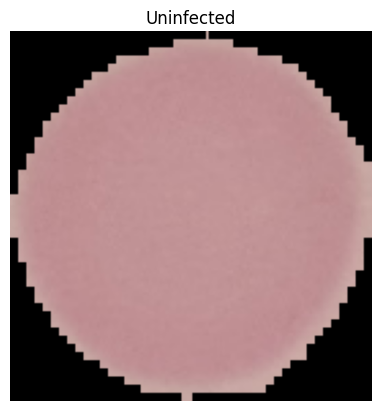

In [ ]:
# view random image
target_class = random.choice(class_names)
img = view_random_image(target_dir='/content/cell_images/', target_class=target_class)

In [ ]:
img

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

### Loading and preparing dataset

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

IMAGE_SIZE = (224, 224)  # Suitable for ResNet50, VGG16, etc.
BATCH_SIZE = 32

# Path to your dataset folder
DATASET_DIR = 'cell_images/'

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

# Load training data
train_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    rescale=1./255,        # Normalize
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Load validation data
val_generator = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    rescale=1./255,
    validation_split=0.2
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


## Model building

### Creating callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Model checkpoint
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Reduce Learning Rate on Plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)